# CALSNIC Dataset

In [14]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from utility.survival import make_time_bins
from SurvivalEVAL.Evaluations.util import KaplanMeier

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

date_cols = ['Visit_Date', 'CNSLS_Date', 'Date of death', 'ALSFRS_Date', 'SymptomOnset_Date']
df = pd.read_csv(Path.joinpath(cfg.CALSNIC_DATA_DIR, 'calsnic_processed.csv'), index_col=0, parse_dates=date_cols)
event_cols = ['Speech', 'Swallowing', 'Handwriting', 'Walking']

# Rename columns for readability
df = df.rename({"Event_Speech": "Speech",
                "Event_Swallowing": "Swallowing",
                "Event_Handwriting": "Handwriting",
                "Event_Walking": "Walking",
                'Event_Death': "Death"}, axis=1)

In [10]:
df.columns

Index(['PSCID', 'Visit', 'Symptom_Duration', 'Visit_details', 'Visit_Date',
       'CNSLS_Date', 'CNSLS_TotalScore', 'Status', 'Date of death',
       'Cause of death', 'ALSFRS_Date', 'ALSFRS_1_Speech',
       'ALSFRS_2_Salivation', 'ALSFRS_3_Swallowing', 'ALSFRS_Bulbar_Subscore',
       'ALSFRS_4_Handwriting', 'ALSFRS_GastrostomyPresent',
       'ALSFRS_5_Cuttingfood&handlingutensils', 'ALSFRS_6_Dressing&hygiene',
       'ALSFRS_Fine Motor_subscore', 'ALSFRS_7_Turninginbed',
       'ALSFRS_8_Walking', 'ALSFRS_9_Climbingstairs',
       'ALSFRS_Gross Motor_subscore', 'ALSFRS_10_Dyspnea',
       'ALSFRS_11_Orthopnea', 'ALSFRS_12_RespiratoryInsufficiency',
       'ALSFRS_Breathing_Subscore', 'ALSFRS_TotalScore',
       'TAP_Trial1RightFinger', 'TAP_Trial1LeftFinger',
       'TAP_Trial2RightFinger', 'TAP_Trial2leftFinger', 'TAP_Trial1RightFoot',
       'TAP_Trial1LeftFoot', 'TAP_Trial2RightFoot', 'TAP_Trial2LeftFoot',
       'TAP_Fingertapping_Right_avg', 'TAP_Fingertapping_Left_avg',
    

[9.900662251655628, 9.625, 9.90625]
[8.364238410596027, 7.886363636363637, 7.5625]
[7.854304635761589, 7.238636363636363, 6.6875]
[11.039735099337749, 10.840909090909092, 10.65625]


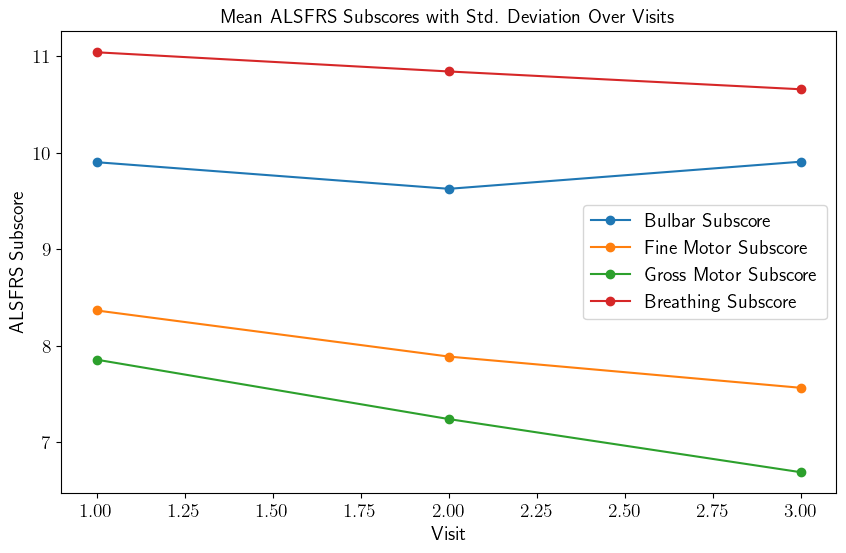

In [24]:
visit_values = [1, 2, 3]
subscores = [
    ('ALSFRS_Bulbar_subscore', 'Bulbar Subscore'),
    ('ALSFRS_FineMotor_subscore', 'Fine Motor Subscore'),
    ('ALSFRS_GrossMotor_subscore', 'Gross Motor Subscore'),
    ('ALSFRS_Breathing_subscore', 'Breathing Subscore')
]

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Loop through each subscore to calculate mean, std and plot
for subscore, label in subscores:
    mean_values = [df[df['Visit'] == v][subscore].mean() for v in visit_values]
    print(mean_values)
    
    # Plot mean line and shaded std area
    plt.plot(visit_values, mean_values, label=label, marker='o')

plt.xlabel('Visit')
plt.ylabel('ALSFRS Subscore')
plt.title('Mean ALSFRS Subscores with Std. Deviation Over Visits')

plt.legend()
plt.show()

In [11]:
for event_col in event_cols:
    obs_arr = np.array(df[event_col])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 152
Number of censored/uncensored: 122/30
80.26% of records are censored

Number of samples: 152
Number of censored/uncensored: 123/29
80.92% of records are censored

Number of samples: 152
Number of censored/uncensored: 121/31
79.61% of records are censored

Number of samples: 152
Number of censored/uncensored: 63/89
41.45% of records are censored



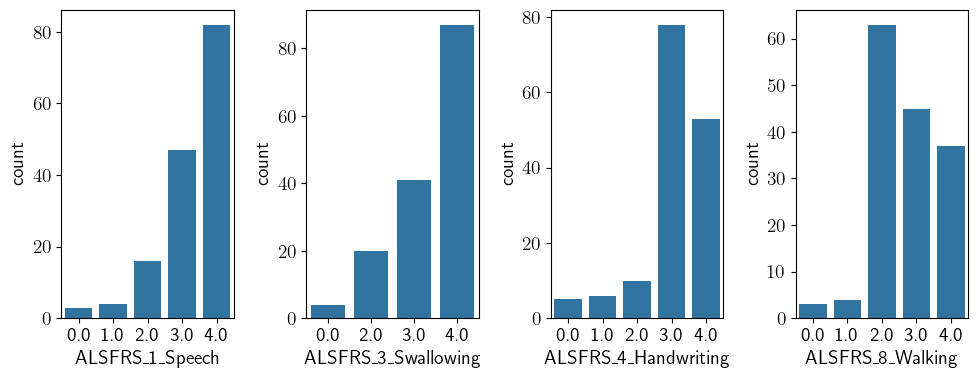

In [3]:
# Plot ALSFRS distribution
alsfrs_cols = ['ALSFRS_1_Speech', 'ALSFRS_3_Swallowing', 'ALSFRS_4_Handwriting', 'ALSFRS_8_Walking']
fig, axs = plt.subplots(ncols=len(alsfrs_cols), figsize=(10,4))
for i, col in enumerate(alsfrs_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
plt.tight_layout()
plt.show()

In [4]:
# Count number of occurances
threshold = 2
for col in alsfrs_cols:
    n_samles_under, n_samples_over = len(df.loc[df[col] <= threshold]), len(df.loc[df[col] > threshold])
    print(f'{n_samles_under} are under {threshold}, {n_samples_over} are over {threshold}')

23 are under 2, 129 are over 2
24 are under 2, 128 are over 2
21 are under 2, 131 are over 2
70 are under 2, 82 are over 2


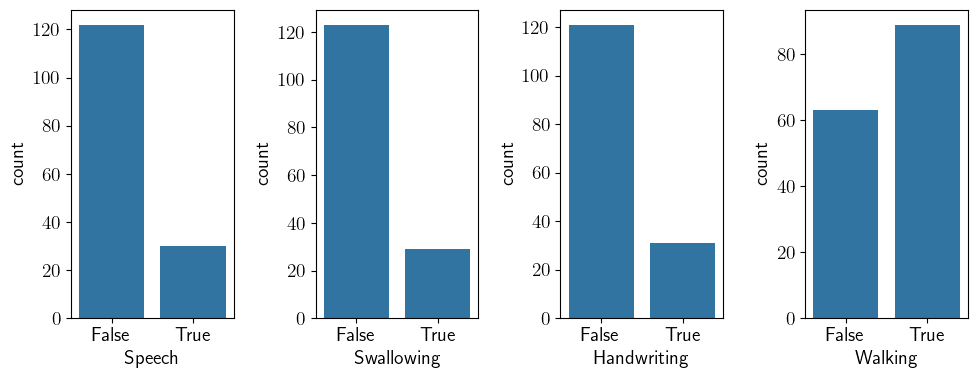

In [5]:
fig, axs = plt.subplots(ncols=len(event_cols), figsize=(10,4))
for i, col in enumerate(event_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
plt.tight_layout()
plt.show()

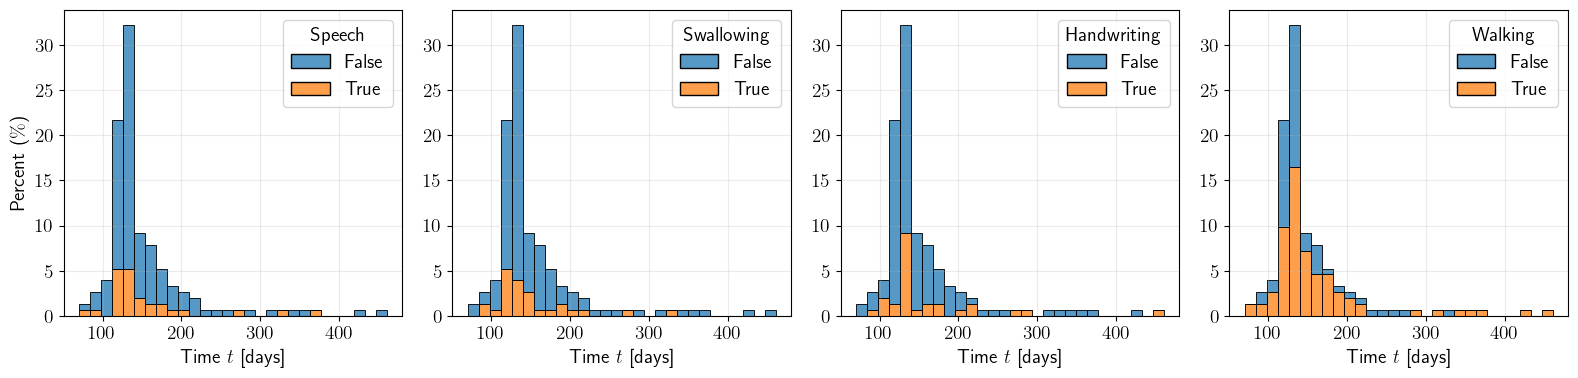

In [6]:
# Plot event distribution
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
axs = axs.flatten()
for i, col in enumerate(event_cols):
    event = df[[f'TTE_{col}', f'{col}']]
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'{col}', multiple="stack", bins="auto", ax=axs[i], stat="percent")
    axs[i].set_xlabel("Time $t$ [days]")
    if i == 0:
        axs[i].set_ylabel("Percent ($\%$)")
    else:
        axs[i].set_ylabel("")
    axs[i].grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/calsnic_event_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()